# Adding Router & Skill Evaluations

The following evaluators will be implemented to assess the performance of the router and the tools:
- an LLM-as-a-judge to evaluate the correctness of the router's function calling choice and the correctness of the parameters extracted;
- an LLM-as-a-judge to evaluate the correctness of the SQL generated by tool 1 and the clarity of the analysis generated by tool 2;
- a code-based evaluator to verify if the code generated by tool 3 is runnable. 


## Importing necessary libraries 

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
import phoenix as px
import os
import json
from tqdm import tqdm
from phoenix.evals import (
    TOOL_CALLING_PROMPT_TEMPLATE, 
    llm_classify,
    OpenAIModel
)
from phoenix.trace import SpanEvaluations
from phoenix.trace.dsl import SpanQuery
from openinference.instrumentation import suppress_tracing

import nest_asyncio
nest_asyncio.apply()

`llm_classify` is used to define LLM-as-a-judge evaluator by defining the model objects to `llm_classify`.

In [21]:
PROJECT_NAME = "evaluating-agent"

In [22]:
from utils import run_agent, start_main_span, tools, get_phoenix_endpoint

The utils file contains the same instrumented agent code that was created in part 2 " evaluating agent"

## Running Agent with a Set of Testing Questions

1- A set of questions will be run to evaluate the agent. 

2- For each question, spans are collected and  are sent to Phoenix.

3- To evaluate an agent component, some specific spans are queied and are used as testing examples for evaluators. 

4- The evaluated spans are uplpoaded to Phoenix.



In [5]:
agent_questions = [
    "What was the most popular product SKU?",
    "What was the total revenue across all stores?",
    "Which store had the highest sales volume?",
    "Create a bar chart showing total sales by store",
    "What percentage of items were sold on promotion?",
    "What was the average transaction value?"
]

for question in tqdm(agent_questions, desc="Processing questions"):
    try:
        ret = start_main_span([{"role": "user", "content": question}])
    except Exception as e:
        print(f"Error processing question: {question}")
        print(e)
        continue

Processing questions:   0%|          | 0/6 [00:00<?, ?it/s]

Starting main span with messages: [{'role': 'user', 'content': 'What was the most popular product SKU?'}]
Running agent with messages: [{'role': 'user', 'content': 'What was the most popular product SKU?'}]
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span


Processing questions:  17%|█▋        | 1/6 [00:03<00:16,  3.22s/it]

Received response with tool calls: False
No tool calls, returning final response
Starting main span with messages: [{'role': 'user', 'content': 'What was the total revenue across all stores?'}]
Running agent with messages: [{'role': 'user', 'content': 'What was the total revenue across all stores?'}]
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span


Processing questions:  33%|███▎      | 2/6 [00:06<00:12,  3.11s/it]

Received response with tool calls: False
No tool calls, returning final response
Starting main span with messages: [{'role': 'user', 'content': 'Which store had the highest sales volume?'}]
Running agent with messages: [{'role': 'user', 'content': 'Which store had the highest sales volume?'}]
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span


Processing questions:  50%|█████     | 3/6 [00:09<00:08,  2.98s/it]

Received response with tool calls: False
No tool calls, returning final response
Starting main span with messages: [{'role': 'user', 'content': 'Create a bar chart showing total sales by store'}]
Running agent with messages: [{'role': 'user', 'content': 'Create a bar chart showing total sales by store'}]
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span


Processing questions:  67%|██████▋   | 4/6 [00:41<00:29, 14.65s/it]

Received response with tool calls: False
No tool calls, returning final response
Starting main span with messages: [{'role': 'user', 'content': 'What percentage of items were sold on promotion?'}]
Running agent with messages: [{'role': 'user', 'content': 'What percentage of items were sold on promotion?'}]
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span


Processing questions:  83%|████████▎ | 5/6 [00:44<00:10, 10.30s/it]

Received response with tool calls: False
No tool calls, returning final response
Starting main span with messages: [{'role': 'user', 'content': 'What was the average transaction value?'}]
Running agent with messages: [{'role': 'user', 'content': 'What was the average transaction value?'}]
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span


Processing questions: 100%|██████████| 6/6 [00:46<00:00,  7.72s/it]

Received response with tool calls: False
No tool calls, returning final response


## Link to Phoenix UI

In [6]:
print(get_phoenix_endpoint())

http://localhost:6006/


## Router Evals using LLM-as-a-Judge

To evaluate the router, you will use this template provided by Phoenix to the LLM-as-a-Judge. 

In [6]:
print(TOOL_CALLING_PROMPT_TEMPLATE)


You are an evaluation assistant evaluating questions and tool calls to
determine whether the tool called would answer the question. The tool
calls have been generated by a separate agent, and chosen from the list of
tools provided below. It is your job to decide whether that agent chose
the right tool to call.

    [BEGIN DATA]
    ************
    [Question]: {question}
    ************
    [Tool Called]: {tool_call}
    [END DATA]

Your response must be single word, either "correct" or "incorrect",
and should not contain any text or characters aside from that word.
"incorrect" means that the chosen tool would not answer the question,
the tool includes information that is not presented in the question,
or that the tool signature includes parameter values that don't match
the formats specified in the tool signatures below.

"correct" means the correct tool call was chosen, the correct parameters
were extracted from the question, the tool call generated is runnable and correct,
and tha

### Querying the Required Spans

In [7]:
query = SpanQuery().where(
    # Filter for the `LLM` span kind.
    # The filter condition is a string of valid Python boolean expression.
    "span_kind == 'LLM'",
).select(
    # input.value and llm.tools are the ones that can be found in the pheonix trace.
   
    question="input.value",
    tool_call="llm.tools"
)

# The Phoenix Client can take this query and return the dataframe.
tool_calls_df = px.Client().query_spans(query, 
                                        project_name=PROJECT_NAME, 
                                        timeout=None)
tool_calls_df = tool_calls_df.dropna(subset=["tool_call"])

tool_calls_df.head()

,question,tool_call
context.span_id,,
c60a84f6885137b1,"{""messages"": [{""role"": ""user"", ""content"": ""Wha...","[{'tool': {'json_schema': '{""type"": ""function""..."
387d718644e695b1,"{""messages"": [{""role"": ""user"", ""content"": ""Wha...","[{'tool': {'json_schema': '{""type"": ""function""..."
af66b12d6bce1672,"{""messages"": [{""role"": ""user"", ""content"": ""Wha...","[{'tool': {'json_schema': '{""type"": ""function""..."
ec0a6853188f9693,"{""messages"": [{""role"": ""user"", ""content"": ""Wha...","[{'tool': {'json_schema': '{""type"": ""function""..."
320e48bef0285bae,"{""messages"": [{""role"": ""user"", ""content"": ""Whi...","[{'tool': {'json_schema': '{""type"": ""function""..."


### Evaluating Tool Calling

In [8]:
with suppress_tracing():
    tool_call_eval = llm_classify(
        dataframe = tool_calls_df,
        template = TOOL_CALLING_PROMPT_TEMPLATE.template[0].template.replace("{tool_definitions}", 
                                                                 json.dumps(tools).replace("{", '"').replace("}", '"')),
        rails = ['correct', 'incorrect'],
        model=OpenAIModel(model="gpt-4o"),
        provide_explanation=True
    )

tool_call_eval['score'] = tool_call_eval.apply(lambda x: 1 if x['label']=='correct' else 0, axis=1)

tool_call_eval.head()

llm_classify |██████████| 25/25 (100.0%) | ⏳ 00:18<00:00 |  1.34it/s


,label,explanation,exceptions,execution_status,execution_seconds,score
context.span_id,,,,,,
c60a84f6885137b1,correct,The question asks for the most popular product...,[],COMPLETED,7.684840,1
387d718644e695b1,incorrect,The question asks for the most popular product...,[],COMPLETED,2.429578,0
af66b12d6bce1672,correct,The question asks for the total revenue across...,[],COMPLETED,2.423872,1
ec0a6853188f9693,correct,The question asks for the total revenue across...,[],COMPLETED,2.608717,1
320e48bef0285bae,correct,The question asks for the store with the highe...,[],COMPLETED,7.684645,1


In [9]:
px.Client().log_evaluations(
    SpanEvaluations(eval_name="Tool Calling Eval", dataframe=tool_call_eval),
)

## Evaluating Python Code Gen (Tool 3 - Data Visualization Evals)

In [10]:
query = SpanQuery().where(
    "name =='generate_visualization'"
).select(
    generated_code="output.value"
)

# The Phoenix Client can take this query and return the dataframe.
code_gen_df = px.Client().query_spans(query, 
                                      project_name=PROJECT_NAME, 
                                      timeout=None)

code_gen_df.head()

,generated_code
context.span_id,
93c9ca7406a49f90,import pandas as pd\nimport matplotlib.pyplot ...


In [11]:
def code_is_runnable(output: str) -> bool:
    """Check if the code is runnable"""
    output = output.strip()
    output = output.replace("```python", "").replace("```", "")
    try:
        exec(output)
        return True
    except Exception as e:
        return False

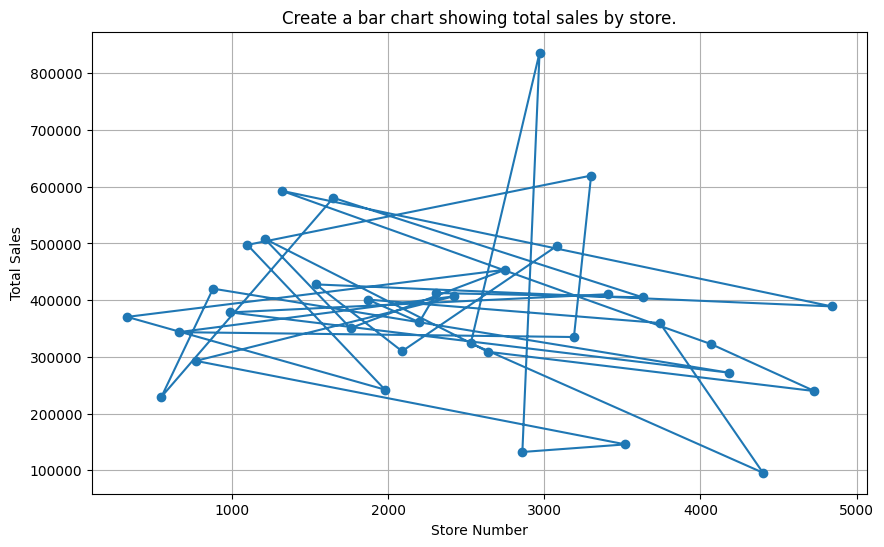

In [12]:
code_gen_df["label"] = code_gen_df["generated_code"].apply(code_is_runnable).map({True: "runnable", False: "not_runnable"})
code_gen_df["score"] = code_gen_df["label"].map({"runnable": 1, "not_runnable": 0})


In [13]:
code_gen_df.head()

,generated_code,label,score
context.span_id,,,
93c9ca7406a49f90,import pandas as pd\nimport matplotlib.pyplot ...,runnable,1


In [14]:
px.Client().log_evaluations(
    SpanEvaluations(eval_name="Runnable Code Eval", dataframe=code_gen_df),
)

## Evaluating Analysis Clarity (Tool 2 - Data Analysis Evals)

In [15]:
CLARITY_LLM_JUDGE_PROMPT = """
In this task, you will be presented with a query and an answer. Your objective is to evaluate the clarity 
of the answer in addressing the query. A clear response is one that is precise, coherent, and directly 
addresses the query without introducing unnecessary complexity or ambiguity. An unclear response is one 
that is vague, disorganized, or difficult to understand, even if it may be factually correct.

Your response should be a single word: either "clear" or "unclear," and it should not include any other 
text or characters. "clear" indicates that the answer is well-structured, easy to understand, and 
appropriately addresses the query. "unclear" indicates that some part of the response could be better 
structured or worded.
Please carefully consider the query and answer before determining your response.

After analyzing the query and the answer, you must write a detailed explanation of your reasoning to 
justify why you chose either "clear" or "unclear." Avoid stating the final label at the beginning of your 
explanation. Your reasoning should include specific points about how the answer does or does not meet the 
criteria for clarity.

[BEGIN DATA]
Query: {query}
Answer: {response}
[END DATA]
Please analyze the data carefully and provide an explanation followed by your response.

EXPLANATION: Provide your reasoning step by step, evaluating the clarity of the answer based on the query.
LABEL: "clear" or "unclear"
"""

In [16]:
query = SpanQuery().where(
    "span_kind=='AGENT'"
).select(
    response="output.value",
    query="input.value"
)

# The Phoenix Client can take this query and return the dataframe.
clarity_df = px.Client().query_spans(query, 
                                     project_name=PROJECT_NAME,
                                     timeout=None)

clarity_df.head()

,response,query
context.span_id,,
3f971d58c2efe1ab,It seems that I'm unable to access the sales d...,"[{""role"": ""user"", ""content"": ""What was the mos..."
c2a122c8b376eb90,It seems that I'm unable to access the dataset...,"[{""role"": ""user"", ""content"": ""What was the tot..."
15bf2ede49d16844,It seems there's an issue accessing the sales ...,"[{""role"": ""user"", ""content"": ""Which store had ..."
4cdcd11cd9a8a598,It seems there was an error accessing the data...,"[{""role"": ""user"", ""content"": ""Create a bar cha..."
c83b47abb21d3ec9,It seems that I'm unable to access the data at...,"[{""role"": ""user"", ""content"": ""What percentage ..."


In [17]:
with suppress_tracing():
    clarity_eval = llm_classify(
        dataframe = clarity_df,
        template = CLARITY_LLM_JUDGE_PROMPT,
        rails = ['clear', 'unclear'],
        model=OpenAIModel(model="gpt-4o"),
        provide_explanation=True
    )

clarity_eval['score'] = clarity_eval.apply(lambda x: 1 if x['label']=='clear' else 0, axis=1)

clarity_eval.head()

llm_classify |██████████| 12/12 (100.0%) | ⏳ 00:08<00:00 |  1.41it/s


,label,explanation,exceptions,execution_status,execution_seconds,score
context.span_id,,,,,,
3f971d58c2efe1ab,unclear,The query asks for the most popular product SK...,[],COMPLETED,6.004743,0
c2a122c8b376eb90,clear,The query asks for the total revenue across al...,[],COMPLETED,6.515987,1
15bf2ede49d16844,clear,The query asks for specific information about ...,[],COMPLETED,5.006408,1
4cdcd11cd9a8a598,clear,The query asks for the creation of a bar chart...,[],COMPLETED,4.380564,1
c83b47abb21d3ec9,unclear,The query asks for a specific percentage of it...,[],COMPLETED,4.832669,0


In [18]:
px.Client().log_evaluations(
    SpanEvaluations(eval_name="Response Clarity", dataframe=clarity_eval),
)

## Evaluating SQL Code Generation (Tool 1 - Database Lookup Evals)

In [23]:
SQL_EVAL_GEN_PROMPT = """
SQL Evaluation Prompt:
-----------------------
You are tasked with determining if the SQL generated appropiately answers a given instruction
taking into account its generated query and response.

Data:
-----
- [Instruction]: {question}
  This section contains the specific task or problem that the sql query is intended to solve.

- [Reference Query]: {query_gen}
  This is the sql query submitted for evaluation. Analyze it in the context of the provided
  instruction.

Evaluation:
-----------
Your response should be a single word: either "correct" or "incorrect".
You must assume that the db exists and that columns are appropiately named.
You must take into account the response as additional information to determine the correctness.

- "correct" indicates that the sql query correctly solves the instruction.
- "incorrect" indicates that the sql query correctly does not solve the instruction correctly.

Note: Your response should contain only the word "correct" or "incorrect" with no additional text
or characters.
"""

In [24]:
query = SpanQuery().where(
    "span_kind=='LLM'"
).select(
    query_gen="llm.output_messages",
    question="input.value",
)

# The Phoenix Client can take this query and return the dataframe.
sql_df = px.Client().query_spans(query, 
                                 project_name=PROJECT_NAME,
                                 timeout=None)
sql_df = sql_df[sql_df["question"].str.contains("Generate an SQL query based on a prompt.", na=False)]

sql_df.head()

,query_gen,question
context.span_id,,
992618cdc67d7e33,[{'message': {'content': '```sql SELECT SKU_Co...,"{""messages"": [{""role"": ""user"", ""content"": ""\nG..."
babf91de2462c4c1,[{'message': {'content': '```sql SELECT SUM(To...,"{""messages"": [{""role"": ""user"", ""content"": ""\nG..."
71cd845d3bd0211f,[{'message': {'content': '```sql SELECT Store_...,"{""messages"": [{""role"": ""user"", ""content"": ""\nG..."
3b59295d2227fa18,[{'message': {'content': '```sql SELECT Store_...,"{""messages"": [{""role"": ""user"", ""content"": ""\nG..."
31d6d8e82040642a,[{'message': {'content': '```sql SELECT (...,"{""messages"": [{""role"": ""user"", ""content"": ""\nG..."


In [25]:
with suppress_tracing():
    sql_gen_eval = llm_classify(
        dataframe = sql_df,
        template = SQL_EVAL_GEN_PROMPT,
        rails = ['correct', 'incorrect'],
        model=OpenAIModel(model="gpt-4o"),
        provide_explanation=True
    )

sql_gen_eval['score'] = sql_gen_eval.apply(lambda x: 1 if x['label']=='correct' else 0, axis=1)

sql_gen_eval.head()

llm_classify |██████████| 6/6 (100.0%) | ⏳ 00:08<00:00 |  1.39s/it


,label,explanation,exceptions,execution_status,execution_seconds,score
context.span_id,,,,,,
992618cdc67d7e33,correct,The task is to find the most popular product S...,[],COMPLETED,3.212465,1
babf91de2462c4c1,correct,The SQL query provided is `SELECT SUM(Total_Sa...,[],COMPLETED,7.342246,1
71cd845d3bd0211f,correct,The SQL query provided correctly calculates th...,[],COMPLETED,2.891749,1
3b59295d2227fa18,correct,The SQL query provided correctly calculates th...,[],COMPLETED,3.202479,1
31d6d8e82040642a,correct,The SQL query provided calculates the percenta...,[],COMPLETED,3.580748,1


In [26]:
px.Client().log_evaluations(
    SpanEvaluations(eval_name="SQL Gen Eval", dataframe=sql_gen_eval),
)